In [3]:
# ติดตั้ง Library ที่จำเป็น
!pip install tensorflow scikit-learn

# Import Libraries ที่ต้องใช้
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# เชื่อมต่อ Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- โหลดข้อมูล ---
# กำหนด path ของไฟล์ข้อมูลที่เราเตรียมไว้ใน Phase 1
data_path = '/content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/02_data/set50_processed_data.csv'

# อ่านไฟล์ CSV เข้าไปใน DataFrame
df = pd.read_csv(data_path, index_col='Date', parse_dates=True)

print("ข้อมูลตัวอย่าง 5 แถวสุดท้าย:")
print(df.tail())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ข้อมูลตัวอย่าง 5 แถวสุดท้าย:
                                  Open         High          Low        Close  \
Date                                                                            
2025-08-18 00:00:00+07:00  1260.229980  1260.229980  1242.310059  1242.310059   
2025-08-19 00:00:00+07:00  1238.849976  1248.400024  1235.760010  1235.760010   
2025-08-20 00:00:00+07:00  1234.489990  1251.140015  1228.430054  1248.130005   
2025-08-21 00:00:00+07:00  1252.609985  1254.520020  1243.530029  1244.790039   
2025-08-22 00:00:00+07:00  1247.250000  1257.989990  1245.300049  1253.390015   

                            Volume  Dividends  Stock Splits     RSI_14  \
Date                                                                     
2025-08-18 00:00:00+07:00  3479100        0.0           0.0  58.013826   
2025-08-19 00:00:00+07:00  3308400        0.0       

In [4]:
# --- 1. ปรับสเกลข้อมูล ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# --- 2. แบ่งข้อมูล Train/Test ---
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_size, :]
test_data = scaled_data[training_size - 60: , :] # -60 เพื่อให้ test set แรกมีข้อมูลครบ 60 วัน

# --- 3. สร้างชุดข้อมูลแบบหน้าต่าง (Windowing) ---
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :] # ข้อมูล 60 วัน (features ทั้งหมด)
        dataX.append(a)
        dataY.append(dataset[i + time_step, 3]) # ราคาปิด (คอลัมน์ที่ 3) ของวันถัดไป
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("Shape ของ X_train:", X_train.shape) # (จำนวนตัวอย่าง, จำนวนวัน, จำนวน features)
print("Shape ของ y_train:", y_train.shape)

Shape ของ X_train: (1852, 60, 16)
Shape ของ y_train: (1852,)


In [5]:
# สร้างโมเดล Sequential
model = Sequential()

# Layer ที่ 1: LSTM layer แรก + Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2)) # Dropout ป้องกัน Overfitting

# Layer ที่ 2: LSTM layer ที่สอง + Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer ที่ 3: Output Layer
model.add(Dense(units=1)) # ทำนายค่าเดียวคือราคาปิด

# Compile โมเดล
model.compile(optimizer='adam', loss='mean_squared_error')

# แสดงสรุปสถาปัตยกรรมของโมเดล
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,651 (131.45 KB)

 Trainable params: 33,651 (131.45 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# เริ่มการฝึกสอนโมเดล
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50, # จำนวนรอบในการสอน
    batch_size=64, # ขนาดของข้อมูลในแต่ละครั้งที่ป้อน
    verbose=1
)

# --- บันทึกโมเดลที่เทรนเสร็จแล้ว ---
model_path = '/content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/03_models/lstm_benchmark_model.h5'
model.save(model_path)
print(f"โมเดลถูกบันทึกเรียบร้อยที่: {model_path}")

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.1756 - val_loss: 0.0331
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0146 - val_loss: 0.0034
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0084 - val_loss: 6.4593e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0068 - val_loss: 7.5046e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0059 - val_loss: 6.9871e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0061 - val_loss: 5.3870e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0051 - val_loss: 5.4930e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0053 - val_loss: 8.1337e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0054 - val_loss: 5.0642e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.0044 - val_loss: 6.1497e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0049 - val_loss: 4.9845e-04
Epoch 12/50
29/29 ━━━━━━━

โมเดลถูกบันทึกเรียบร้อยที่: /content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/03_models/lstm_benchmark_model.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test RMSE: 20.55 Baht


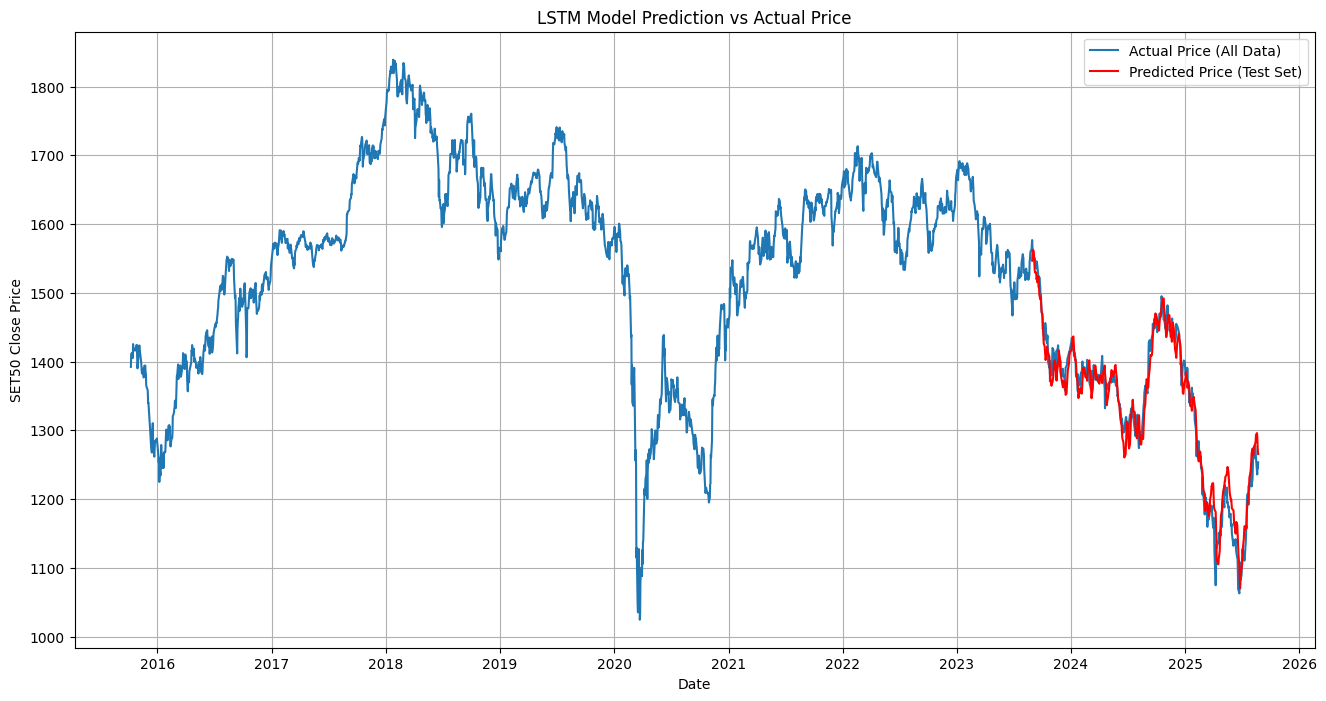

In [8]:
# --- ทำนายข้อมูล Train และ Test ---
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# --- แปลงค่าที่ทำนายกลับเป็นสเกลราคาปกติ (Inverse Transform) ---
# สร้าง dummy array ที่มีจำนวนคอลัมน์เท่ากับข้อมูลดั้งเดิม
train_predict_full = np.zeros(shape=(len(train_predict), scaled_data.shape[1]) )
# ใส่ค่าที่ทำนายลงในคอลัมน์ของราคาปิด (คอลัมน์ที่ 3)
train_predict_full[:,3] = train_predict.flatten()
# ทำ Inverse Transform
train_predict_inv = scaler.inverse_transform(train_predict_full)[:,3]

test_predict_full = np.zeros(shape=(len(test_predict), scaled_data.shape[1]) )
test_predict_full[:,3] = test_predict.flatten()
test_predict_inv = scaler.inverse_transform(test_predict_full)[:,3]

# --- คำนวณค่า RMSE (Root Mean Squared Error) ---
rmse = np.sqrt(mean_squared_error(df['Close'][len(train_data):len(train_data)+len(test_predict_inv)], test_predict_inv))
print(f"Test RMSE: {rmse:.2f} Baht")

# --- แสดงผลด้วยกราฟ ---
plt.figure(figsize=(16,8))
plt.title('LSTM Model Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('SET50 Close Price')

# พล็อตข้อมูลจริง
plt.plot(df.index, df['Close'], label='Actual Price (All Data)')

# พล็อตข้อมูลที่ทำนาย (Test set)
# บรรทัดนี้ผิด
#test_dates = df.index[training_size+time_step+1 : training_size+time_step+1+len(test_predict_inv)]
# แก้เป็นบรรทัดนี้
test_dates = df.index[-len(test_predict_inv):]
plt.plot(test_dates, test_predict_inv, label='Predicted Price (Test Set)', color='red')

plt.legend()
plt.grid(True)
plt.show()